<a href="https://colab.research.google.com/github/Mateusz-best-creator/Learning_ML/blob/main/Book_Chapter2_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pathlib import Path
import tarfile
import urllib.request

def loading_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url="https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = loading_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Understanding our dataset

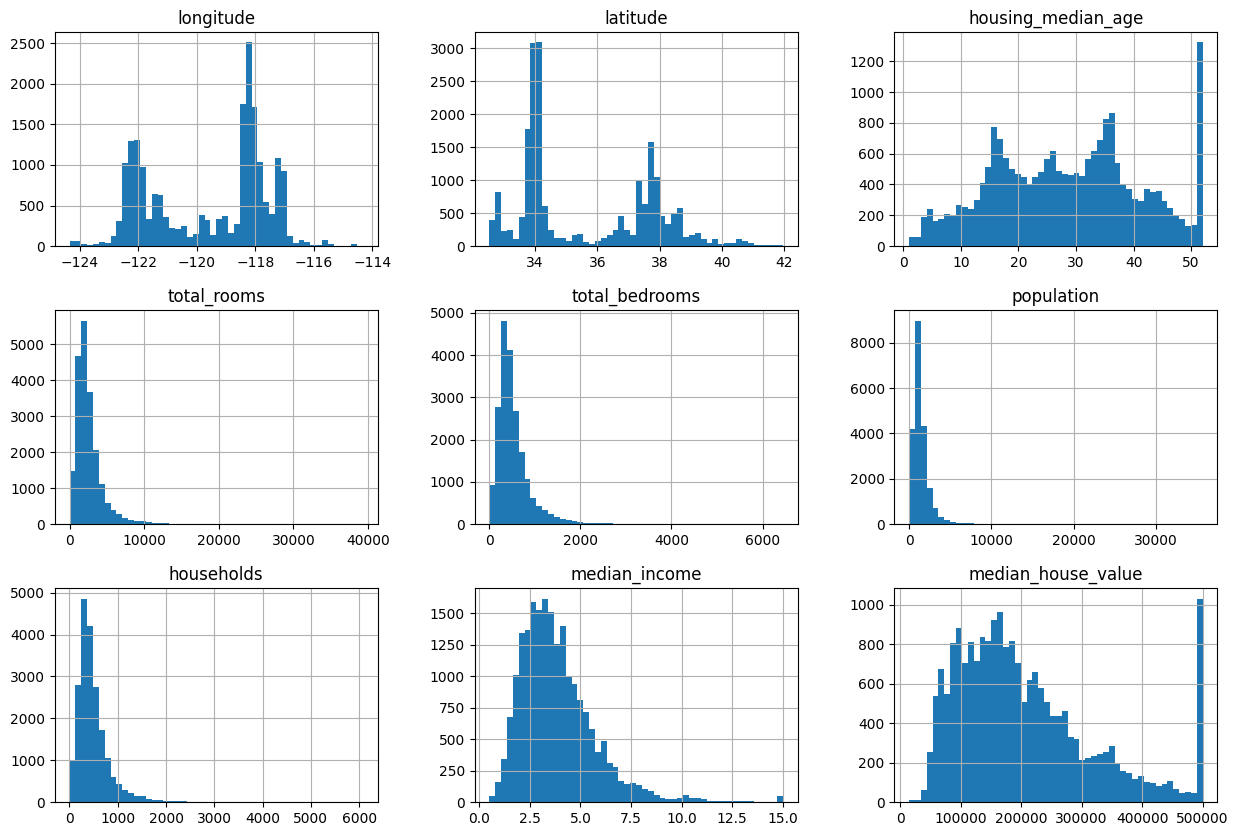

In [ ]:
housing.hist(bins=50, figsize=(15, 10))
plt.show()

Based on above plots we see that we will want to apply logarithmic transformations to:

- total_rooms
- total_bedrooms
- population
- households
- median_income
- median_house_value

In [ ]:
# Let's check features correlation
housing.drop("ocean_proximity", axis=1).corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [ ]:
# Now lets add some more features and see if they are relevant!
housing["people_per_household"] = housing["population"] / housing["households"]
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]

In [ ]:
# Let's check features correlation
housing.drop("ocean_proximity", axis=1).corr()["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688075
rooms_per_household     0.151948
total_rooms             0.134153
housing_median_age      0.105623
households              0.065843
total_bedrooms          0.049686
people_per_household   -0.023737
population             -0.024650
longitude              -0.045967
latitude               -0.144160
bedrooms_per_room      -0.255880
Name: median_house_value, dtype: float64

## Creating data sets

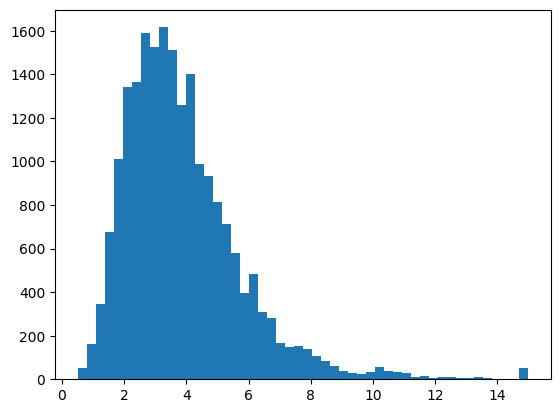

In [ ]:
plt.hist(housing["median_income"], bins=50)
plt.figsize=(5,3)

In [ ]:
# since median_income is very imporant, we will create buckets and use stratified sampling to ensute that each set has same amount of similar incomes
housing["income_cat"] = pd.cut(x=housing["median_income"], bins=[0.,1.5,3.,4.5,6.,7.5,np.inf])
pd.Series(housing["income_cat"].value_counts() / len(housing)).sort_values(ascending=False)

income_cat
(3.0, 4.5]    0.350581
(1.5, 3.0]    0.318847
(4.5, 6.0]    0.176308
(6.0, 7.5]    0.068944
(7.5, inf]    0.045494
(0.0, 1.5]    0.039826
Name: count, dtype: float64

In [ ]:
X = housing.drop("median_house_value", axis=1)
Y = housing["median_house_value"]
X.shape, Y.shape

((20640, 13), (20640,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=X["income_cat"])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16512, 13), (4128, 13), (16512,), (4128,))

In [ ]:
pd.Series(X_train["income_cat"].value_counts() / len(X_train)).sort_values(ascending=False)

income_cat
(3.0, 4.5]    0.350594
(1.5, 3.0]    0.318859
(4.5, 6.0]    0.176296
(6.0, 7.5]    0.068920
(7.5, inf]    0.045482
(0.0, 1.5]    0.039850
Name: count, dtype: float64

In [ ]:
pd.Series(X_test["income_cat"].value_counts() / len(X_test)).sort_values(ascending=False)

income_cat
(3.0, 4.5]    0.350533
(1.5, 3.0]    0.318798
(4.5, 6.0]    0.176357
(6.0, 7.5]    0.069041
(7.5, inf]    0.045543
(0.0, 1.5]    0.039729
Name: count, dtype: float64

In [ ]:
# Now lets remove redundant column, put test set aside and create validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=X_train["income_cat"])
X_train.drop("income_cat", axis=1, inplace=True)
X_valid.drop("income_cat", axis=1, inplace=True)
X_test.drop("income_cat", axis=1, inplace=True)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((13209, 12), (3303, 12), (13209,), (3303,))

## Create data Pipelines

In [ ]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_household,rooms_per_household,bedrooms_per_room
5323,-122.69,38.34,12.0,3876.0,782.0,2146.0,764.0,4.0844,<1H OCEAN,2.808901,5.073298,0.201754
13122,-115.73,33.36,19.0,749.0,238.0,476.0,169.0,1.7727,INLAND,2.816568,4.431953,0.317757
15393,-121.83,37.27,14.0,2855.0,380.0,1420.0,383.0,6.6712,<1H OCEAN,3.707572,7.454308,0.133100
1875,-118.38,34.17,33.0,1588.0,454.0,739.0,392.0,2.8208,<1H OCEAN,1.885204,4.051020,0.285894
15202,-122.83,38.39,19.0,1765.0,394.0,868.0,388.0,2.4620,<1H OCEAN,2.237113,4.548969,0.223229


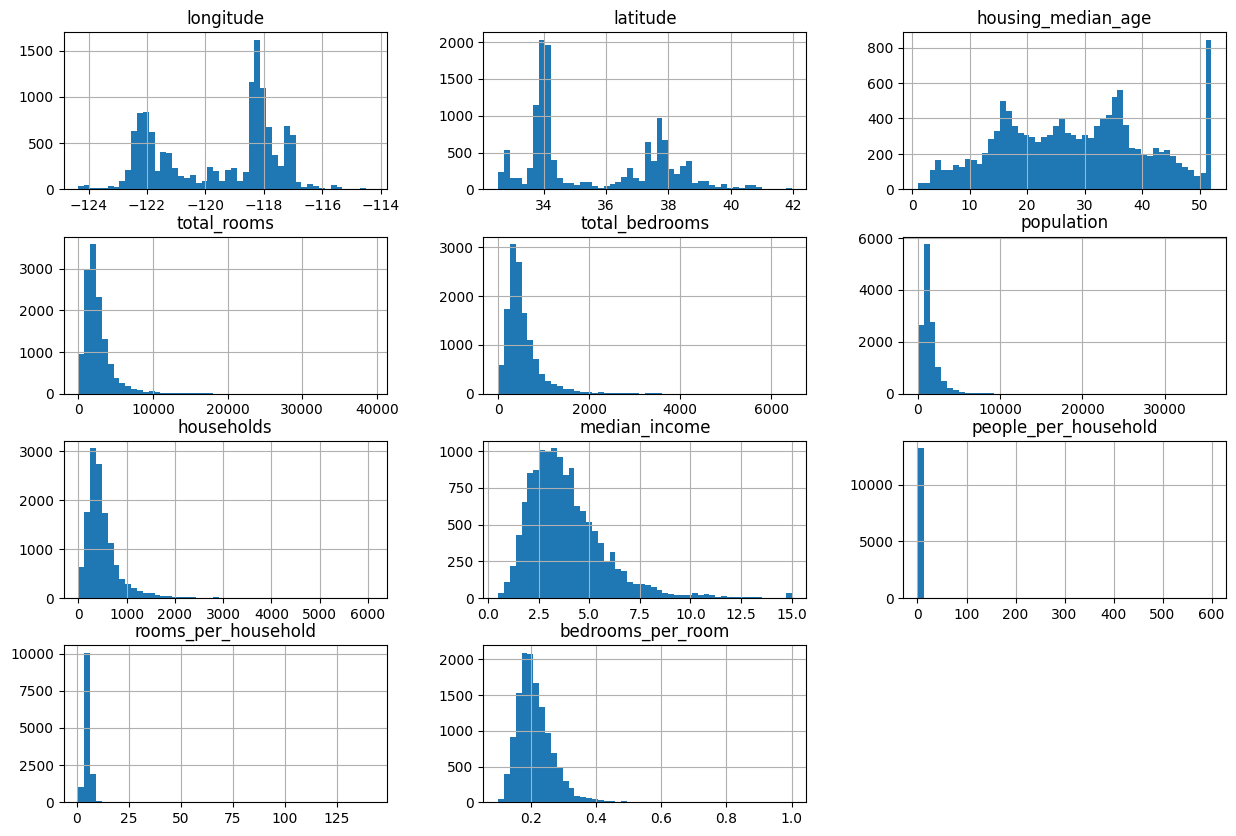

In [ ]:
X_train.hist(bins=50, figsize=(15, 10))
plt.show()

### Custom data transformer

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             StandardScaler())
log_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             FunctionTransformer(func=np.log, inverse_func=np.exp),
                             StandardScaler())
# Create final preprocessing
preprocessing = ColumnTransformer(transformers=[
    ("categorical", cat_pipeline, ["ocean_proximity"]),
    ("logarithmic", log_pipeline, ["total_rooms", "total_bedrooms", "population",
                                   "households", "median_income",
                                   "rooms_per_household", "bedrooms_per_room", "people_per_household"]),
], remainder=default_num_pipeline)

preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity']),
                                ('logarithmic',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      inverse_func=<ufunc 'exp'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'rooms_per_household', 'bedrooms_per_room',
                                  'people_per_household'])])

In [ ]:
X_train_ready = preprocessing.fit_transform(X_train)
X_valid_ready = preprocessing.fit_transform(X_valid)

In [ ]:
pd.DataFrame(X_train_ready).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,0.0,0.0,0.0,0.0,0.836658,0.826138,0.866979,0.887085,0.346346,-0.082888,-0.097381,-0.035977,-1.567055,1.285341,-1.314009
1,0.0,1.0,0.0,0.0,0.0,-1.361480,-0.808065,-1.176863,-1.176580,-1.429963,-0.573307,1.773975,-0.025874,1.905721,-1.054707,-0.757277
2,1.0,0.0,0.0,0.0,0.0,0.427829,-0.165282,0.306532,-0.057475,1.390471,1.313430,-1.811014,0.992742,-1.137948,0.782560,-1.154943
3,1.0,0.0,0.0,0.0,0.0,-0.356576,0.079145,-0.579865,-0.025704,-0.441399,-0.899422,1.338657,-1.513760,0.583471,-0.674097,0.356186
4,1.0,0.0,0.0,0.0,0.0,-0.215265,-0.115580,-0.361502,-0.039733,-0.730927,-0.478743,0.319332,-0.879482,-1.636910,1.308836,-0.757277


## Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model = make_pipeline(preprocessing, RandomForestRegressor())
rf_model.fit(X_train, y_train)
rmse_rf_model = mean_squared_error(y_true=y_valid, y_pred=rf_model.predict(X_valid), squared=False)
print(f"RMSE of random forest model on validation set = {rmse_rf_model}")

RMSE of random forest model on validation set = 50277.58940335887


In [ ]:
from sklearn.model_selection import cross_val_score

scores_random_forest = -cross_val_score(estimator=rf_model,
                                        X=X_train,
                                        y=y_train,
                                        cv=3,
                                        verbose=2,
                                        scoring="neg_root_mean_squared_error")
print(scores_random_forest)

[CV] END .................................................... total time=  10.6s
[CV] END .................................................... total time=   9.9s
[CV] END .................................................... total time=   9.8s
[51327.00147567 50452.28079714 54547.3586391 ]


In [ ]:
from sklearn.svm import SVR, LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

svr_model = make_pipeline(preprocessing, SelectFromModel(estimator=LinearSVR()), SVR())
scores_svr = -cross_val_score(estimator=svr_model,
                                        X=X_train,
                                        y=y_train,
                                        cv=3,
                                        verbose=2,
                                        scoring="neg_root_mean_squared_error")
print(scores_svr)

[CV] END .................................................... total time=   8.6s
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   7.8s
[113950.9958006  119141.87589162 120239.47443663]


## Search for best Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
# defining parameter range
svr_param_grid = {'svr__C': [0.1, 1, 10],
              'svr__gamma': [1, 0.1, 0.01],
              'svr__kernel': ['rbf', "linear"]}

svr_search = GridSearchCV(estimator=svr_model,
                          param_grid=svr_param_grid,
                          scoring="neg_root_mean_squared_error",
                          verbose=2,
                          cv=3)
svr_search.fit(X_train.iloc[:5000], y_train.iloc[:5000])
svr_search.best_params_

In [ ]:
mean_squared_error(y_valid, svr_search.predict(X_valid), squared=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

svr_dist = {"svr__C": np.linspace(0.01, 50, 100),
            'svr__gamma': np.linspace(0.01, 10, 50),
            'svr__kernel': ['rbf', "linear"]}

svr_random_search = RandomizedSearchCV(estimator=svr_model,
                                       param_distributions=svr_dist,
                                       verbose=2,
                                       n_iter=15,
                                       cv=3)
svr_random_search.fit(X_train.iloc[:5000], y_train.iloc[:5000])
svr_random_search.best_params_

In [ ]:
mean_squared_error(y_valid, svr_random_search.predict(X_valid), squared=False)

In [ ]:
rf_dist = {'randomforestregressor__bootstrap': [True, False],
            'randomforestregressor__max_depth': [10, 20],
            # 'randomforestregressor__max_features': ['auto', 'sqrt'],
            # 'randomforestregressor__min_samples_leaf': [1, 2, 4],
            # 'randomforestregressor__min_samples_split': [2, 5, 10],
            'randomforestregressor__n_estimators': [200, 1000, 1800]}

rf_random_search = GridSearchCV(estimator=rf_model,
                                param_grid=rf_dist,
                                verbose=2,
                                cv=3)
rf_random_search.fit(X_train, y_train)
rf_random_search.best_params_

In [ ]:
mean_squared_error(y_valid, rf_random_search.predict(X_valid), squared=False)

## StandardScaler Clone

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class StandardScaler(BaseEstimator, TransformerMixin):

  def __init__(self):
    self.mean = None
    self.std = None

  def fit(self, X, y=None):
    self.mean = X.mean()
    self.std = X.std()
    return self

  def transform(self, X):
    X = X - self.mean
    return X / self.std

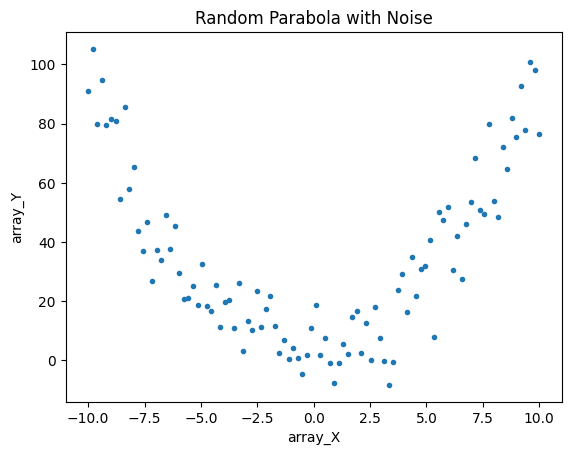

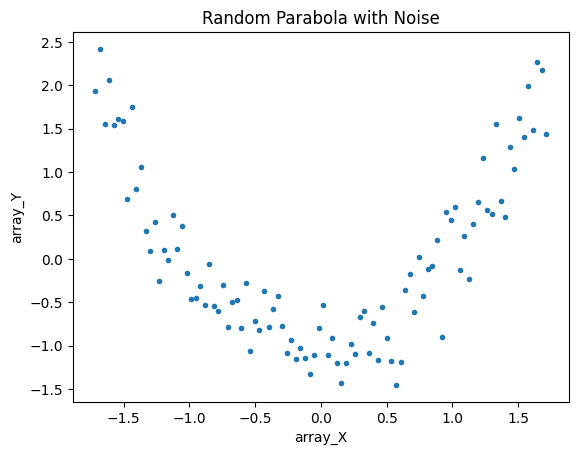

In [ ]:
array_X = np.linspace(-10, 10, 100)
noise = np.random.normal(0, 10, array_X.shape)
array_Y = array_X**2 + noise

# Plot array_X and array_Y
plt.plot(array_X, array_Y, 'o', markersize=3)
plt.xlabel('array_X')
plt.ylabel('array_Y')
plt.title('Random Parabola with Noise')
plt.show()

scaler = StandardScaler()
scaled_X = scaler.fit_transform(array_X)
scaled_Y = scaler.fit_transform(array_Y)

plt.plot(scaled_X, scaled_Y, 'o', markersize=3)
plt.xlabel('array_X')
plt.ylabel('array_Y')
plt.title('Random Parabola with Noise')
plt.show()